<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/prakriti_MHCglobe_code_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking if my implementation that draws upon Eric's individual functions is correct

Current implementation: v1_troubleshoot_MHCGlobe_pipeline

1. Load all individual models
2. Train all of them on the entire database (just check that example data is not in here- I see there is overlap!!)
3. Predict each one on 100 random HLA samples
4. Take the average
5. It should line up with what Eric has in the workflow -
This time, I retrained the initial models using Eric's tutorial code and compared results to mine. They were different!

**Error from Last Time**.
I trained and tested Eric's ensemble with the test data!

**Observations from this iteration**.
Fixed above error in this iteration.
Results were significantly worse for the ensemble.
My pipeline did better.

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 716, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 716 (delta 96), reused 63 (delta 24), pack-reused 549
Receiving objects: 100% (716/716), 112.68 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (394/394), done.
Updating files: 100% (198/198), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240327T195824.054874209.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can in

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf

### Get data
Contains both BA+EL, human and non-human

In [4]:
import mhc_data
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data
# pMHC_data.shape

#### Randomly pick 100 HLA-peptide peptide + Remove them from training data
These will be the test set, and is the same number of examples as in Eric's example df

In [5]:
# 678024
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]
# 100 A LOT of non ='s for some reason...
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=16)

# Seeing what happens if I only have ='s
# human_pMHC_data_test = human_pMHC_data.iloc[:100]

# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

In [6]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
644669,HLA-B*27:05,S3_Only,<,SA,100.0,RRFSRSDELTR,HLA-B,True,True
717608,HLA-B*51:01,S3_Only,<,SA,100.0,LPLPGSLL,HLA-B,True,True
115916,HLA-B*35:01,IEDB,=,BA,48.4,TLMAAILAY,HLA-B,True,True
723110,HLA-B*57:01,S3_Only,<,SA,100.0,KSGLNIAHF,HLA-B,True,True
264187,HLA-B*44:02,IEDB,<,SA,100.0,QEMFPQVPYHL,HLA-B,True,True
519974,HLA-A*02:07,S3_Only,<,SA,100.0,LLPSKAYTV,HLA-A,True,True
71415,HLA-B*08:01,IEDB,=,BA,370.0,EFINKFLEF,HLA-B,True,True
274126,HLA-C*05:01,IEDB,<,SA,100.0,FQDDNNLYL,HLA-C,True,True
35073,HLA-A*03:01,IEDB,=,BA,70100.0,NAMSFDGFIR,HLA-A,True,True
196907,HLA-A*29:02,IEDB,<,SA,100.0,YFFDNPRRY,HLA-A,True,True


#### Reset Indices to prevent any issues downstream

In [7]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [8]:
pMHC_data_train = pMHC_data_train.reset_index(drop=True)
human_pMHC_data_test = human_pMHC_data_test.reset_index(drop=True)

In [9]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [10]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-B*27:05,S3_Only,<,SA,100.0,RRFSRSDELTR,HLA-B,True,True
1,HLA-B*51:01,S3_Only,<,SA,100.0,LPLPGSLL,HLA-B,True,True
2,HLA-B*35:01,IEDB,=,BA,48.4,TLMAAILAY,HLA-B,True,True
3,HLA-B*57:01,S3_Only,<,SA,100.0,KSGLNIAHF,HLA-B,True,True
4,HLA-B*44:02,IEDB,<,SA,100.0,QEMFPQVPYHL,HLA-B,True,True
5,HLA-A*02:07,S3_Only,<,SA,100.0,LLPSKAYTV,HLA-A,True,True
6,HLA-B*08:01,IEDB,=,BA,370.0,EFINKFLEF,HLA-B,True,True
7,HLA-C*05:01,IEDB,<,SA,100.0,FQDDNNLYL,HLA-C,True,True
8,HLA-A*03:01,IEDB,=,BA,70100.0,NAMSFDGFIR,HLA-A,True,True
9,HLA-A*29:02,IEDB,<,SA,100.0,YFFDNPRRY,HLA-A,True,True


#### Get 4 relevant columns

In [11]:
pMHC_data_train = pMHC_data_train[["allele", "peptide", "measurement_inequality", "measurement_value"]]
human_pMHC_data_test = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [12]:
pMHC_data_train.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
5,HLA-A*11:01,RLYYDSMSY,=,237.025000
6,HLA-A*11:01,AVLQSGFRK,=,56.833333
7,HLA-A*03:01,KCYGVSATK,=,2069.000000
8,HLA-A*11:01,KCYGVSATK,=,8375.750000
9,HLA-A*03:01,QLFKPLTKK,=,188.033333


In [13]:
human_pMHC_data_test.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-B*27:05,RRFSRSDELTR,<,100.0
1,HLA-B*51:01,LPLPGSLL,<,100.0
2,HLA-B*35:01,TLMAAILAY,=,48.4
3,HLA-B*57:01,KSGLNIAHF,<,100.0
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0
5,HLA-A*02:07,LLPSKAYTV,<,100.0
6,HLA-B*08:01,EFINKFLEF,=,370.0
7,HLA-C*05:01,FQDDNNLYL,<,100.0
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0
9,HLA-A*29:02,YFFDNPRRY,<,100.0


### Make X_tr, Y_tr, X_es, Y_es for training

In [ ]:
import mhcglobe
# loads the init model
ensemble = mhcglobe.ensemble(train_type="init")
# DOES depend on init/full!
setup_data_training = ensemble.setup_data_training(pMHC_data_train)
# I don't think this is deterministic
X_tr, Y_tr, X_es, Y_es = setup_data_training

### Load base tensorflow models individually and train
Idea is that these trained models should be equivalent to full models that are loaded into the ensemble, and used for final predictions.

In [ ]:
import train_functions as trainf
model_dir = "/content/mhcglobe/model/mhcglobe/init/"

model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")
model_2 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model37_fold15_ONE_HOT_init/")
model_3 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model79_fold9_ONE_HOT_init/")

In [ ]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_1
new_model_1 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [ ]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_2
new_model_2 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [ ]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_3
new_model_3 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

### Predict individually on example data

In [ ]:
# prediction 1
import sequence_functions as seqf
import binding_affinity as ba

to_predict = human_pMHC_data_test
X = seqf.get_XY(to_predict, encode_type="ONE_HOT", get_Y=False)


In [ ]:
def get_prediction_df(new_model, X, to_predict):
  mhcglobe_scores = new_model.predict(X)

  # Get them
  mhcglobe_scores = mhcglobe_scores.flatten()
  mhcglobe_affinities = list(map(ba.to_ic50, mhcglobe_scores))

  prediction_dict = {"mhcglobe_affinities": mhcglobe_affinities, "mhcglobe_scores": mhcglobe_scores}
  prediction_df = pd.DataFrame(prediction_dict)

  # Munge to_predict so I can correctly concatenate the columns
  munged_to_predict = to_predict
  munged_to_predict.index = prediction_df.index

  # Present the data nicely!
  prediction_df_all = pd.concat([munged_to_predict, prediction_df], axis=1)
  return(prediction_df_all)


In [ ]:
prediction_df_1 = get_prediction_df(new_model_1, X, to_predict)
prediction_df_1.head(10)

4/4 [==============================] - 0s 4ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,93.754480,0.580335
1,HLA-B*51:01,LPLPGSLL,<,100.0,162.128999,0.529714
2,HLA-B*35:01,TLMAAILAY,=,48.4,264.807631,0.484370
3,HLA-B*57:01,KSGLNIAHF,<,100.0,116.119178,0.560562
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,138.041707,0.544579
5,HLA-A*02:07,LLPSKAYTV,<,100.0,62.841475,0.617311
6,HLA-B*08:01,EFINKFLEF,=,370.0,323.736701,0.465800
7,HLA-C*05:01,FQDDNNLYL,<,100.0,80.778534,0.594103
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0,650.152634,0.401355
9,HLA-A*29:02,YFFDNPRRY,<,100.0,91.998535,0.582083


In [ ]:
prediction_df_2 = get_prediction_df(new_model_2, X, to_predict)
prediction_df_2.head(10)

4/4 [==============================] - 0s 3ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,101.398648,0.573091
1,HLA-B*51:01,LPLPGSLL,<,100.0,101.822164,0.572706
2,HLA-B*35:01,TLMAAILAY,=,48.4,124.363205,0.554223
3,HLA-B*57:01,KSGLNIAHF,<,100.0,97.239102,0.576962
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,96.871750,0.577312
5,HLA-A*02:07,LLPSKAYTV,<,100.0,95.356315,0.578770
6,HLA-B*08:01,EFINKFLEF,=,370.0,172.708466,0.523871
7,HLA-C*05:01,FQDDNNLYL,<,100.0,98.842577,0.575451
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0,7884.485283,0.170718
9,HLA-A*29:02,YFFDNPRRY,<,100.0,93.626808,0.580461


In [ ]:
prediction_df_3 = get_prediction_df(new_model_3, X, to_predict)
prediction_df_3.head(10)

4/4 [==============================] - 0s 3ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,101.688687,0.572827
1,HLA-B*51:01,LPLPGSLL,<,100.0,90.271809,0.583834
2,HLA-B*35:01,TLMAAILAY,=,48.4,122.931625,0.555293
3,HLA-B*57:01,KSGLNIAHF,<,100.0,101.998893,0.572546
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,93.947253,0.580145
5,HLA-A*02:07,LLPSKAYTV,<,100.0,98.153300,0.576098
6,HLA-B*08:01,EFINKFLEF,=,370.0,148.536361,0.537807
7,HLA-C*05:01,FQDDNNLYL,<,100.0,87.591513,0.586620
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0,14906.039475,0.111856
9,HLA-A*29:02,YFFDNPRRY,<,100.0,75.430103,0.600435


### Get average results

In [ ]:
# Average mhcglobe_scores
mhcglobe_affinities_df1 = prediction_df_1['mhcglobe_affinities']
mhcglobe_affinities_df2 = prediction_df_2['mhcglobe_affinities']
mhcglobe_affinities_df3 = prediction_df_3['mhcglobe_affinities']

In [ ]:
mhcglobe_affinities_df1.head(5)

0     93.754480
1    162.128999
2    264.807631
3    116.119178
4    138.041707
Name: mhcglobe_affinities, dtype: float64

In [ ]:
mhcglobe_affinities_df2.head(5)

0    101.398648
1    101.822164
2    124.363205
3     97.239102
4     96.871750
Name: mhcglobe_affinities, dtype: float64

In [ ]:
mhcglobe_affinities_df3.head(5)

0    101.688687
1     90.271809
2    122.931625
3    101.998893
4     93.947253
Name: mhcglobe_affinities, dtype: float64

In [ ]:
all_affinities = pd.concat([mhcglobe_affinities_df1, mhcglobe_affinities_df2, mhcglobe_affinities_df3], axis=1)
all_affinities.head(5)

,mhcglobe_affinities,mhcglobe_affinities,mhcglobe_affinities
0,93.754480,101.398648,101.688687
1,162.128999,101.822164,90.271809
2,264.807631,124.363205,122.931625
3,116.119178,97.239102,101.998893
4,138.041707,96.871750,93.947253


In [ ]:
average_mhcglobe_affinities = all_affinities.mean(axis=1)
average_mhcglobe_affinities.head(5)

0     98.947272
1    118.074324
2    170.700820
3    105.119058
4    109.620237
dtype: float64

### Compare with true values

In [ ]:
human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]].head(5)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-B*27:05,RRFSRSDELTR,<,100.0
1,HLA-B*51:01,LPLPGSLL,<,100.0
2,HLA-B*35:01,TLMAAILAY,=,48.4
3,HLA-B*57:01,KSGLNIAHF,<,100.0
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0


In [ ]:
prediction_df_comparison = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]
prediction_df_comparison["predicted_mhcglobe_affinities"] = average_mhcglobe_affinities
prediction_df_comparison

<ipython-input-83-793e7b2bb1ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df_comparison["predicted_mhcglobe_affinities"] = average_mhcglobe_affinities


,allele,peptide,measurement_inequality,measurement_value,predicted_mhcglobe_affinities
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,98.947272
1,HLA-B*51:01,LPLPGSLL,<,100.0,118.074324
2,HLA-B*35:01,TLMAAILAY,=,48.4,170.700820
3,HLA-B*57:01,KSGLNIAHF,<,100.0,105.119058
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,109.620237
...,...,...,...,...,...
95,HLA-B*40:02,WEKEEQEIL,<,100.0,97.578552
96,HLA-A*68:02,QGVNDNEEGFFSAR,<,100.0,135.807454
97,HLA-B*27:05,ISRNQKLLQ,<,100.0,116.133170
98,HLA-A*02:06,ETQSGALEV,=,9615.0,1510.635964


### Plot + Get r^2

In [23]:
import matplotlib.pyplot as plt
def make_scatter_plot(df, x_col, y_col):
  plt.scatter(df[x_col], df[y_col])
  plt.xlabel(x_col)
  plt.ylabel(y_col)
  plt.title("Scatter Plot")
  plt.show()

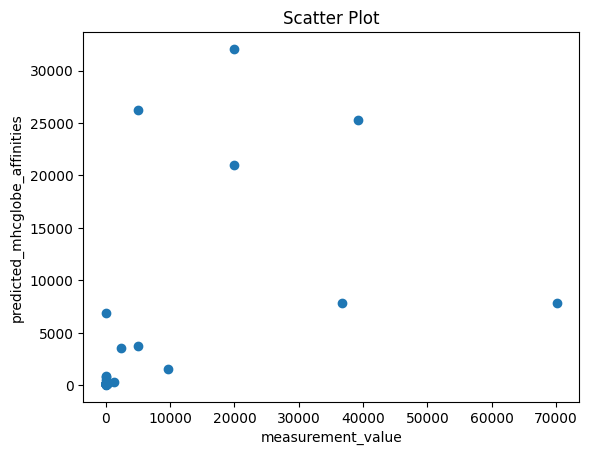

In [ ]:
make_scatter_plot(prediction_df_comparison, "measurement_value", "predicted_mhcglobe_affinities")

In [24]:
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

def get_r_squared_mse(df, x_col, y_col):
  slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
  mse = mean_squared_error(df[x_col], df[y_col])
  return(r_value**2, mse)

In [ ]:
my_predictions_r, my_predictions_mse = get_r_squared_mse(prediction_df_comparison, "measurement_value", "predicted_mhcglobe_affinities")
print("R-squared:", my_predictions_r)
print("MSE:", my_predictions_mse)

R-squared: 0.32643101790012236
MSE: 56223663.03905643


## What happens if I use his tutorial code?

### Wrapper Functions

In [29]:
def get_ensemble_predictions(new_mhcglobe_path, df_train, df_test, verbose):
  """
  Get predictions for all models in new_mhcglobe_path.
  Args:
    df_train:
      Dataframe with cols: "allele" "peptide" "measurement_value"
      e.g. df_train = human_pMHC_data_test[["allele", "peptide", "measurement_value"]]

  Returns:
    ensemble_predictions:
      Dataframe with cols:
      (13, 14, ONE_HOT)	(15, 37, ONE_HOT)	(9, 79, ONE_HOT)	mhcglobe_score	mhcglobe_affinity
  """
  # Make the initial ensemble
  init_ensemble = mhcglobe.ensemble(train_type='init', new_mhcglobe_path=new_mhcglobe_path)

  # Train all init models. They will appear in new_mhcglobe_path.
  new_model_list = list()
  new_model_paths = mhcglobe.LoadMHCGlobe().new_model_paths(new_mhcglobe_path)

  i = 0
  for init_model, new_model_path in zip(init_ensemble.ensemble_base_models, new_model_paths):
    print(f"Training model {i}")
    assert not os.path.exists(new_model_path), 'Already trained: {}'.format(new_model_path)
    # Data
    X_tr, Y_tr, X_es, Y_es = init_ensemble.setup_data_training(df_train)
    # Train
    new_model = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)
    # Save them
    new_model_list.append(new_model)
    i += 1

  # Predict
  # Get X
  X = seqf.get_XY(df_test, encode_type=init_ensemble.protein_encoding, get_Y=False)

  ensemble_predictions = pd.DataFrame()
  base_model_predictions = []
  j = 0
  for model in new_model_list:
    print(f"Predicting for model {j}")
    predictions = pd.DataFrame(model.predict(X, verbose=0))
    base_model_predictions.append(predictions)
    j += 1

  ensemble_predictions = pd.concat(base_model_predictions, axis=1, ignore_index=True)
  ensemble_predictions.loc[:, 'mhcglobe_score'] = np.mean(ensemble_predictions, axis=1)
  ensemble_predictions.loc[:, 'mhcglobe_affinity'] = list(map(ba.to_ic50, ensemble_predictions['mhcglobe_score']))
  ensemble_predictions.columns = init_ensemble.hparam_ids + ['mhcglobe_score', 'mhcglobe_affinity']

  return ensemble_predictions

In [30]:
# ~11 mins to run!
new_mhcglobe_path = "/content/mhcglobe/outputs/"
df_train, df_test, verbose = pMHC_data_train, human_pMHC_data_test, 0
ensemble_predictions = get_ensemble_predictions(new_mhcglobe_path, df_train, df_test, verbose)

Training model 0
Training model 1
Training model 2
Predicting for model 0
Predicting for model 1
Predicting for model 2


In [31]:
def make_comparison_df(ensemble_predictions, df_test):
  """
  Concatenates ensemble_predictions and df_test.

  Returns:
    df_comparison:
      Dataframe with cols: "allele" "peptide" "measurement_value" "mhcglobe_affinity"
  """
  ensemble_predictions.index = df_test.index
  df_comparison = pd.concat([df_test, ensemble_predictions], axis=1)
  df_comparison = df_comparison.loc[:, ['allele', 'peptide', 'measurement_value', 'mhcglobe_affinity']]
  return df_comparison


In [33]:
ensemble_comparison_df = make_comparison_df(ensemble_predictions, df_test)
ensemble_comparison_df

,allele,peptide,measurement_value,mhcglobe_affinity
0,HLA-B*27:05,RRFSRSDELTR,100.0,100.639156
1,HLA-B*51:01,LPLPGSLL,100.0,127.712104
2,HLA-B*35:01,TLMAAILAY,48.4,192.685680
3,HLA-B*57:01,KSGLNIAHF,100.0,111.358069
4,HLA-B*44:02,QEMFPQVPYHL,100.0,110.542299
...,...,...,...,...
95,HLA-B*40:02,WEKEEQEIL,100.0,103.028646
96,HLA-A*68:02,QGVNDNEEGFFSAR,100.0,143.271115
97,HLA-B*27:05,ISRNQKLLQ,100.0,125.368985
98,HLA-A*02:06,ETQSGALEV,9615.0,1546.675913


### Initial Raw Cells!

In [15]:
new_mhcglobe_path = "/content/mhcglobe/outputs/example_mhcglobe/"
eric_init_ensemble = mhcglobe.ensemble(train_type='init', new_mhcglobe_path=new_mhcglobe_path)

print(eric_init_ensemble.ensemble_base_models)
print(eric_init_ensemble.ensemble_model_paths)

[<keras.src.engine.functional.Functional object at 0x7e815bbee800>, <keras.src.engine.functional.Functional object at 0x7e815c877430>, <keras.src.engine.functional.Functional object at 0x7e815c2f0fd0>]
['/content/mhcglobe/model/mhcglobe/init/model14_fold13_ONE_HOT_init', '/content/mhcglobe/model/mhcglobe/init/model37_fold15_ONE_HOT_init', '/content/mhcglobe/model/mhcglobe/init/model79_fold9_ONE_HOT_init']


### Train and save 3 models

In [16]:
df_train = pMHC_data_train
verbose = 0

new_model_list = list()
new_model_paths = mhcglobe.LoadMHCGlobe().new_model_paths(new_mhcglobe_path)
for init_model, new_model_path in zip(eric_init_ensemble.ensemble_base_models, new_model_paths):
            assert not os.path.exists(new_model_path), 'Already trained: {}'.format(new_model_path)

            # Data
            X_tr, Y_tr, X_es, Y_es = eric_init_ensemble.setup_data_training(df_train)

            # Train
            new_model = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

            # # Save them
            new_model_list.append(new_model)

# They are called _model14_fold13_ONE_HOT...

### Lines with issues

In [ ]:
# There's something wrong with this line (last line of .train_ensemble)
# ???
returned_ensemble = mhcglobe.ensemble(train_type=None, new_mhcglobe_path=new_mhcglobe_path)

In [ ]:
# Also doesn't work
user_mhcglobe = mhcglobe.ensemble(new_mhcglobe_path=new_model_path)

### So let's expand the individual functions
### The following are predictions

In [17]:
df_test = human_pMHC_data_test
# len 2; 2, 100
X = seqf.get_XY(df_test, encode_type=eric_init_ensemble.protein_encoding, get_Y=False)

In [18]:
# predictions = self.ensemble_predict(X)
ensemble_predictions = pd.DataFrame()
# len=3; 3, 100
base_model_predictions = []
for model in new_model_list:
        predictions = pd.DataFrame(model.predict(X, verbose=0))
        base_model_predictions.append(predictions)
ensemble_predictions = pd.concat(base_model_predictions, axis=1, ignore_index=True)
ensemble_predictions.loc[:, 'mhcglobe_score'] = np.mean(ensemble_predictions, axis=1)
ensemble_predictions.loc[:, 'mhcglobe_affinity'] = list(map(ba.to_ic50, ensemble_predictions['mhcglobe_score']))
ensemble_predictions.columns = eric_init_ensemble.hparam_ids + ['mhcglobe_score', 'mhcglobe_affinity']

In [19]:
ensemble_predictions

,"(13, 14, ONE_HOT)","(15, 37, ONE_HOT)","(9, 79, ONE_HOT)",mhcglobe_score,mhcglobe_affinity
0,0.578736,0.574629,0.572128,0.575164,99.149472
1,0.522569,0.572883,0.571716,0.555723,122.361819
2,0.469842,0.502832,0.528809,0.500495,222.413085
3,0.561004,0.571938,0.589733,0.574225,100.162020
4,0.542757,0.580483,0.557306,0.560182,116.598388
...,...,...,...,...,...
95,0.565179,0.576551,0.583660,0.575130,99.185926
96,0.509438,0.574086,0.570155,0.551226,128.461654
97,0.541641,0.573347,0.553069,0.556019,121.969623
98,0.439999,0.347717,0.336530,0.374749,867.033367


In [21]:
# pd.concat([df, predictions], axis=1)
ensemble_predictions.index = df_test.index
eric_df_comparison = pd.concat([df_test, ensemble_predictions], axis=1)
eric_df_comparison = eric_df_comparison.loc[:, ['allele', 'peptide', 'measurement_value', 'mhcglobe_affinity']]
eric_df_comparison

,allele,peptide,measurement_value,mhcglobe_affinity
0,HLA-B*27:05,RRFSRSDELTR,100.0,99.149472
1,HLA-B*51:01,LPLPGSLL,100.0,122.361819
2,HLA-B*35:01,TLMAAILAY,48.4,222.413085
3,HLA-B*57:01,KSGLNIAHF,100.0,100.162020
4,HLA-B*44:02,QEMFPQVPYHL,100.0,116.598388
...,...,...,...,...
95,HLA-B*40:02,WEKEEQEIL,100.0,99.185926
96,HLA-A*68:02,QGVNDNEEGFFSAR,100.0,128.461654
97,HLA-B*27:05,ISRNQKLLQ,100.0,121.969623
98,HLA-A*02:06,ETQSGALEV,9615.0,867.033367


### Compare with me
Different :(

In [ ]:
prediction_df_comparison

,allele,peptide,measurement_inequality,measurement_value,predicted_mhcglobe_affinities
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,98.947272
1,HLA-B*51:01,LPLPGSLL,<,100.0,118.074324
2,HLA-B*35:01,TLMAAILAY,=,48.4,170.700820
3,HLA-B*57:01,KSGLNIAHF,<,100.0,105.119058
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,109.620237
...,...,...,...,...,...
95,HLA-B*40:02,WEKEEQEIL,<,100.0,97.578552
96,HLA-A*68:02,QGVNDNEEGFFSAR,<,100.0,135.807454
97,HLA-B*27:05,ISRNQKLLQ,<,100.0,116.133170
98,HLA-A*02:06,ETQSGALEV,=,9615.0,1510.635964


### Plot + Get r^2

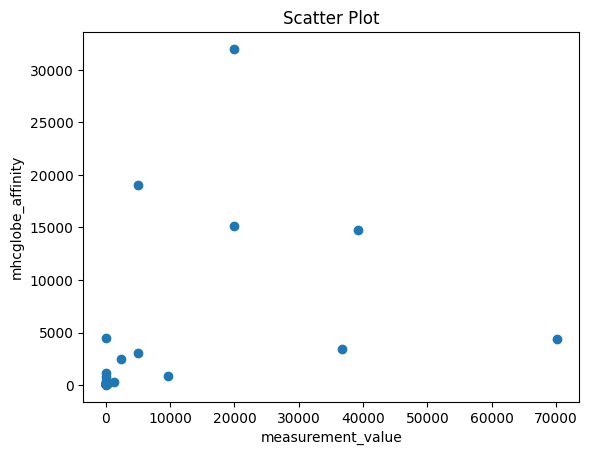

In [25]:
make_scatter_plot(eric_df_comparison, "measurement_value", "mhcglobe_affinity")

In [26]:
eric_predictions_r, eric_predictions_mse = get_r_squared_mse(eric_df_comparison, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_r)
print("MSE:", eric_predictions_mse)

R-squared: 0.22993491672026595
MSE: 64865767.38562275
